In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, EllipticalAperture
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import sep
from matplotlib.patches import Ellipse
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std

In [2]:
surveys={'SDSS':glob('./SDSS/*.fits'),
         '2MASS':glob('./2MASS/*.fits'),
         'GALEX':glob('./GALEX/*'),
         'WISE':glob('./WISE/*')}
targets={'NGC3705': SkyCoord("11:30:07 +09:16:36",unit=('hourangle,deg')),
         'MCG05': SkyCoord("17:06:55 +30:16:11",unit=('hourangle,deg')),
         'MCG06': SkyCoord("12:12:05 +32:44:06",unit=('hourangle,deg')),
         'UGC9379': SkyCoord("14:33:59 +40:14:40",unit=('hourangle,deg')),
         'NVSSJ09': SkyCoord("09:24:57 +40:23:59",unit=('hourangle,deg')),
         'NGC6365A': SkyCoord("17:22:44 +62:09:58",unit=('hourangle,deg')),
         'NGC3016': SkyCoord("09:49:51 +12:41:43",unit=('hourangle,deg'))}

#print(surveys)

In [ ]:

image=fits.open(surveys[survey][0])[0].data
hdr=fits.open(surveys[survey][0])[0].header
wcs=WCS(hdr)
hdr['FILTNAME']

'u'

## SDSS ##

./SDSS/UGC9379.fits
Net 609.091148107783
u_S/N 50.00292445217181
u_Mag= 15.53829428008358  dM= 0.019998830287546638
i_S/N 372.5121634870666
i_Mag= 13.937951241874849  dM=  0.002684476100428649
z_S/N 85.05869116222566
z_Mag= 13.73363859079825  dM=  0.011756588143271329


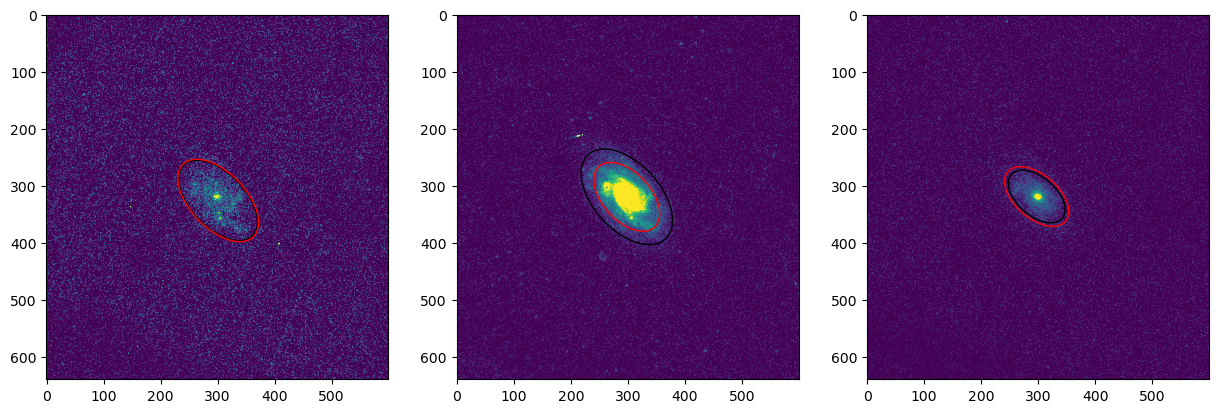

In [43]:
obj_ind=6
survey='SDSS'

print(surveys[survey][obj_ind])
u_hdr=fits.open(surveys[survey][obj_ind])[0].header
i_hdr=fits.open(surveys[survey][obj_ind])[3].header
z_hdr=fits.open(surveys[survey][obj_ind])[4].header
wcs=WCS(u_hdr)
u_im=fits.open(surveys[survey][obj_ind])[0].data.byteswap().newbyteorder()
i_im=fits.open(surveys[survey][obj_ind])[3].data.byteswap().newbyteorder()
z_im=fits.open(surveys[survey][obj_ind])[4].data.byteswap().newbyteorder()
target=surveys[survey][obj_ind].split('/')[-1].split('.')[0]
target_x,target_y=wcs.world_to_pixel(targets[target])
fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))


u_bkg_mean,u_bkg_med,u_bkg_rms=sigma_clipped_stats(u_im[0:100,0:100])
u_objects= sep.extract(u_im,1,err=u_bkg_rms,deblend_cont=1)
ind=np.argmax([el[15]*el[16] for el in u_objects])
x=u_objects['x'][ind]
y=u_objects['y'][ind]
a=u_objects['a'][ind]
b=u_objects['b'][ind]
theta=u_objects['theta'][ind]
e1 = Ellipse(xy=(u_objects['x'][ind], u_objects['y'][ind]),
                width=6*u_objects['a'][ind],
                height=6*u_objects['b'][ind],
                angle=u_objects['theta'][ind] * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('black')
ax1.add_artist(e1)
kronrad, krflag = sep.kron_radius(u_im, [x], [y], [a], [b], [theta], 6.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(u_im, aper)
net=phot_table['aperture_sum'][0]
print('Net',net)
SN_gal=net/np.sqrt((net/u_hdr['GAIN'])+aper.area*u_hdr['RNOISE']**2+aper.area*u_bkg_rms**2)
print('u_S/N',SN_gal)
print('u_Mag=',-2.5*np.log10(float(net))+22.5,' dM=',1/SN_gal)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax1.add_artist(e_app)

i_bkg_mean,i_bkg_med,i_bkg_rms=sigma_clipped_stats(i_im[0:100,0:100])
i_objects= sep.extract(i_im, 1.5,i_bkg_rms,deblend_cont=1)#use if no blending wanted
#print(i_objects['x'])
ind=np.argmin([np.sqrt((i_objects['x'][el]-len(i_im[0])/2)**2+(i_objects['y'][el]-len(i_im)/2)**2) for el in range(len(i_objects))])
x=i_objects['x'][ind]
y=i_objects['y'][ind]
a=i_objects['a'][ind]
b=i_objects['b'][ind]
theta=i_objects['theta'][ind]
e1 = Ellipse(xy=(i_objects['x'][ind], i_objects['y'][ind]),
                width=6*i_objects['a'][ind],
                height=6*i_objects['b'][ind],
                angle=i_objects['theta'][ind] * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('black')
ax2.add_artist(e1)

kronrad, krflag = sep.kron_radius(i_im, [x], [y], [a], [b], [theta], 8.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(i_im, aper)
net=phot_table['aperture_sum'][0]
#SN_gal=net/np.sqrt(net+aper.area*i_bkg_rms)
SN_gal=net/np.sqrt((net/i_hdr['GAIN'])+aper.area*i_hdr['RNOISE']**2+aper.area*i_bkg_rms**2)
print('i_S/N',SN_gal)
print('i_Mag=',-2.5*np.log10(float(net))+22.5,' dM= ',1/SN_gal)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax2.add_artist(e_app)

z_bkg_mean,z_bkg_med,z_bkg_rms=sigma_clipped_stats(z_im[0:100,0:100])
z_objects= sep.extract(z_im,1.5,z_bkg_rms,deblend_cont=1)#use if no blending wanted
#print(z_objects['x'])
ind=np.argmin([np.sqrt((z_objects['x'][el]-len(z_im[0])/2)**2+(z_objects['y'][el]-len(z_im)/2)**2) for el in range(len(z_objects))])
x=z_objects['x'][ind]
y=z_objects['y'][ind]
a=z_objects['a'][ind]
b=z_objects['b'][ind]
theta=z_objects['theta'][ind]
e1 = Ellipse(xy=(z_objects['x'][ind], z_objects['y'][ind]),
                width=6*z_objects['a'][ind],
                height=6*z_objects['b'][ind],
                angle=z_objects['theta'][ind] * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('black')
ax3.add_artist(e1)
kronrad, krflag = sep.kron_radius(z_im, [x], [y], [a], [b], [theta], 8.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(z_im, aper)
net=phot_table['aperture_sum'][0]
#SN_gal=net/np.sqrt(net+aper.area*z_bkg_rms)
SN_gal=net/np.sqrt((net/z_hdr['GAIN'])+aper.area*z_hdr['RNOISE']**2+aper.area*z_bkg_rms**2)
print('z_S/N',SN_gal)
print('z_Mag=',-2.5*np.log10(float(net))+22.5,' dM= ',1/SN_gal)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax3.add_artist(e_app)
ax1.imshow(u_im,vmin=0,vmax=5*u_bkg_rms)
ax2.imshow(i_im,vmin=0,vmax=10*i_bkg_rms)
ax3.imshow(z_im,vmin=0,vmax=10*z_bkg_rms)


## GALEX ##

./GALEX/UGC9379
nuv_S/N 51.01130599524587
nuv_Mag= 16.645149500329996  dM= 0.01960349731279567
nuv_S/N 25.58934377423379
fuv_Mag= 16.883185969056235  dM= 0.039078766881349716


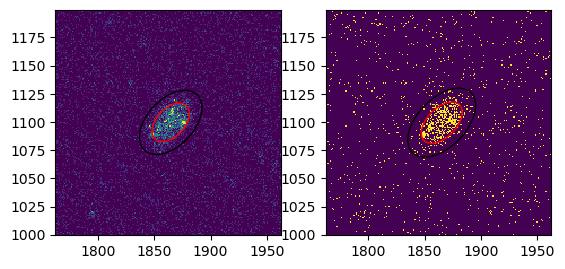

In [9]:
survey='GALEX'
obj_ind=6
obj_fold=surveys[survey][obj_ind]
obj_name=obj_fold.split('/')[-1]
print(obj_fold)
files=glob(obj_fold+'/*')
fuv_im=fits.open([file for file in files if file.endswith('fd-int.fits')][0])[0].data
hdr_nuv=fits.open([file for file in files if file.endswith('nd-int.fits')][0])[0].header
hdr_fuv=fits.open([file for file in files if file.endswith('fd-int.fits')][0])[0].header
nuv_im=fits.open([file for file in files if file.endswith('nd-int.fits')][0])[0].data
fuv_bkg=fits.open([file for file in files if file.endswith('fd-skybg.fits')][0])[0].data
nuv_bkg=fits.open([file for file in files if file.endswith('nd-skybg.fits')][0])[0].data
nuv_expt=float(hdr_nuv['EXPTIME'])
fuv_expt=float(hdr_fuv['EXPTIME'])
f_bkg=sigma_clipped_stats(fuv_bkg)[1]
n_bkg=sigma_clipped_stats(nuv_bkg)[1]
wcs=WCS(hdr_nuv)
fuv1=fuv_im-fuv_bkg
fuv=fuv1
nuv1=nuv_im-nuv_bkg
nuv=nuv1
target_x,target_y=wcs.world_to_pixel(targets[obj_name])
fig, (ax1,ax2) = plt.subplots(1, 2)
tol=100
ax1.imshow(nuv,vmin=0,vmax=0.08,interpolation='none',origin='lower')
ax1.set_xlim(target_x-tol,target_x+tol)
ax1.set_ylim(target_y-tol,target_y+tol)
ax2.imshow(fuv,vmin=0,vmax=0.005,interpolation='none',origin='lower')
ax2.set_xlim(target_x-tol,target_x+tol)
ax2.set_ylim(target_y-tol,target_y+tol)
fuv_bkg_mean,fuv_bkg_med,fuv_bkg_rms=sigma_clipped_stats(fuv)
nuv_bkg_mean,nuv_bkg_med,nuv_bkg_rms=sigma_clipped_stats(nuv)
nuv_objects= sep.extract(nuv,5,err=nuv_bkg_rms,minarea=20,deblend_cont=1)
#print(nuv_objects)
ind=np.argmin([np.sqrt((nuv_objects['x'][el]-target_x)**2+(nuv_objects['y'][el]-target_y)**2) for el in range(len(nuv_objects))])
x=nuv_objects['x'][ind]
y=nuv_objects['y'][ind]
a=nuv_objects['a'][ind]
b=nuv_objects['b'][ind]
theta=nuv_objects['theta'][ind]
kronrad, krflag = sep.kron_radius(nuv, [x], [y], [a], [b], [theta], 6.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(nuv, aper)
net=phot_table['aperture_sum'][0]
SN_gal=(net*nuv_expt)/np.sqrt(net*nuv_expt+aper.area*n_bkg*nuv_expt)
print('nuv_S/N',SN_gal)
print('nuv_Mag=',-2.5*np.log10(float(net))+20.08,' dM=',1/SN_gal)
#dM_nuv=np.sqrt((-2.5*(np.log10(float(net))-np.log10(float(net)+np.sqrt(float(net)*nuv_expt+(0.027*float(net)*nuv_expt)**2)/nuv_expt)))**2+(aper.area*nuv_bkg_rms**2+float(net))/float(net)**2)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax1.add_artist(e_app)
e1 = Ellipse(xy=(nuv_objects['x'][ind], nuv_objects['y'][ind]),
                width=6*nuv_objects['a'][ind],
                height=6*nuv_objects['b'][ind],
                angle=nuv_objects['theta'][ind] * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('black')
ax1.add_artist(e1)


fuv_objects= sep.extract(fuv,2,err=fuv_bkg_rms,minarea=20,deblend_cont=1)
#print(nuv_objects)
ind=np.argmin([np.sqrt((fuv_objects['x'][el]-target_x)**2+(fuv_objects['y'][el]-target_y)**2) for el in range(len(fuv_objects))])
x=fuv_objects['x'][ind]
y=fuv_objects['y'][ind]
a=fuv_objects['a'][ind]
b=fuv_objects['b'][ind]
theta=fuv_objects['theta'][ind]
kronrad, krflag = sep.kron_radius(fuv, [x], [y], [a], [b], [theta], 6.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(fuv, aper)
net=phot_table['aperture_sum'][0]
SN_gal=(net*fuv_expt)/np.sqrt(net*fuv_expt+aper.area*f_bkg*fuv_expt)
print('nuv_S/N',SN_gal)
print('fuv_Mag=',-2.5*np.log10(float(net))+18.82,' dM=',1/SN_gal)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax2.add_artist(e_app)
e1 = Ellipse(xy=(fuv_objects['x'][ind], fuv_objects['y'][ind]),
                width=6*fuv_objects['a'][ind],
                height=6*fuv_objects['b'][ind],
                angle=fuv_objects['theta'][ind] * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('black')
ax2.add_artist(e1)

## 2MASS ##

./2MASS/UGC9379.fits
UGC9379
Net 1272.2395581573073
J_S/N_test 10.413027103474583
J_Mag= 14.050577762225828  dM= 0.09603355393805932
Net 1509.32752708222
H_S/N 8.294100127077307
H_Mag= 14.103041268072895  dM= 0.12056763056613619
Net 1034.5156314874898
K_S/N 6.395505600288263
K_Mag= 14.356157356943482  dM= 0.1563598036650812


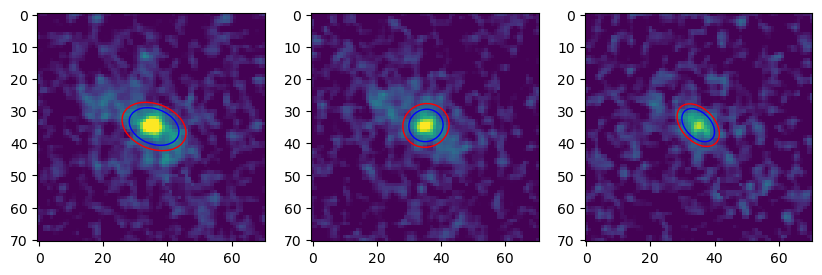

In [27]:
obj_ind=8
survey='2MASS'
obs_thresh=5
#Issue with NGC3016A have to increase object threshold, claims negative sum
#For UGC9379 the higher threshold is also needed due to overestimation of galaxy size
print(surveys[survey][obj_ind])
target=surveys[survey][obj_ind].split('/')[-1].split('.')[0]
print(target)
hdr=fits.open(surveys[survey][obj_ind])[0].header
hdr['CTYPE2']='DEC--SIN'
im=fits.open(surveys[survey][obj_ind])[0].data.byteswap().newbyteorder()
J_im=im[3]
H_im=im[4]
K_im=im[5]
fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(10,5))

J_bkg_mean,J_bkg_med,J_bkg_rms=sigma_clipped_stats(J_im)
J_objects= sep.extract(J_im,obs_thresh,err=J_bkg_rms)
ind=np.argmax([el[15]*el[16] for el in J_objects])
x=J_objects['x'][ind]
y=J_objects['y'][ind]
a=J_objects['a'][ind]
b=J_objects['b'][ind]
theta=J_objects['theta'][ind]
e1 = Ellipse(xy=(x, y),
                width=6*a,
                height=6*b,
                angle=theta * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('blue')
ax1.add_artist(e1)
kronrad, krflag = sep.kron_radius(J_im, [x], [y], [a], [b], [theta], 6.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(J_im, aper)
net=phot_table['aperture_sum'][0]
print('Net',net)
SN_gal=net/np.sqrt(float(hdr['JSKYVAL'])*aper.area+net+aper.area*float(hdr['JSKYSIG'])**2)
SN_test=net/np.sqrt(net/60+4*aper.area*(2*1.7*J_bkg_rms)**2+(4*aper.area*0.024*J_bkg_rms))
#print('J_S/N',SN_gal)
print('J_S/N_test',SN_test)
print('J_Mag=',-2.5*np.log10(float(net))+float(hdr['JMAGZP'])+0.91,' dM=',1/SN_test)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax1.add_artist(e_app)

H_bkg_mean,H_bkg_med,H_bkg_rms=sigma_clipped_stats(H_im)
H_objects= sep.extract(H_im,obs_thresh,err=H_bkg_rms)
ind=np.argmax([el[15]*el[16] for el in H_objects])
x=H_objects['x'][ind]
y=H_objects['y'][ind]
a=H_objects['a'][ind]
b=H_objects['b'][ind]
theta=H_objects['theta'][ind]
e1 = Ellipse(xy=(x, y),
                width=6*a,
                height=6*b,
                angle=theta * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('blue')
ax2.add_artist(e1)
kronrad, krflag = sep.kron_radius(H_im, [x], [y], [a], [b], [theta], 6.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(H_im, aper)
net=phot_table['aperture_sum'][0]
print('Net',net)
#SN_gal=net/np.sqrt(float(hdr['HSKYVAL'])*aper.area+net+aper.area*float(hdr['HSKYSIG'])**2)
SN_test=net/np.sqrt(net/60+4*aper.area*(2*1.7*H_bkg_rms)**2+(4*aper.area*0.024*H_bkg_rms))
print('H_S/N',SN_test)
print('H_Mag=',-2.5*np.log10(float(net))+float(hdr['HMAGZP'])+1.39,' dM=',1/SN_test)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax2.add_artist(e_app)

K_bkg_mean,K_bkg_med,K_bkg_rms=sigma_clipped_stats(K_im)
K_objects= sep.extract(K_im,obs_thresh,err=K_bkg_rms)
ind=np.argmax([el[15]*el[16] for el in K_objects])
x=K_objects['x'][ind]
y=K_objects['y'][ind]
a=K_objects['a'][ind]
b=K_objects['b'][ind]
theta=K_objects['theta'][ind]
kronrad, krflag = sep.kron_radius(K_im, [x], [y], [a], [b], [theta], 6.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(K_im, aper)
net=phot_table['aperture_sum'][0]
print('Net',net)
#SN_gal=net/np.sqrt(float(hdr['KSKYVAL'])*aper.area+net+aper.area*float(hdr['KSKYSIG'])**2)
SN_test=net/np.sqrt(net/60+4*aper.area*(2*1.7*K_bkg_rms)**2+(4*aper.area*0.024*K_bkg_rms))
print('K_S/N',SN_test)
print('K_Mag=',-2.5*np.log10(float(net))+float(hdr['KMAGZP'])+1.85,' dM=',1/SN_test)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
e1 = Ellipse(xy=(x, y),
                width=6*a,
                height=6*b,
                angle=theta * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('blue')
ax3.add_artist(e1)
ax3.add_artist(e_app)
ax1.imshow(J_im,vmin=0,vmax=10*J_bkg_rms)
ax2.imshow(H_im,vmin=0,vmax=10*H_bkg_rms)
ax3.imshow(K_im,vmin=0,vmax=10*K_bkg_rms)

Net 59373.222557039786
J_S/N_test 115.77710993140803
J_Mag= 9.773024336374492  dM= 0.008637285907313184
Net 73831.35339328136
H_S/N 118.09368681200532
H_Mag= 9.613198666267191  dM= 0.008467853168069106
Net 58428.39425105796
K_S/N 65.64953222389737
K_Mag= 9.812140382384838  dM= 0.01523240099547862


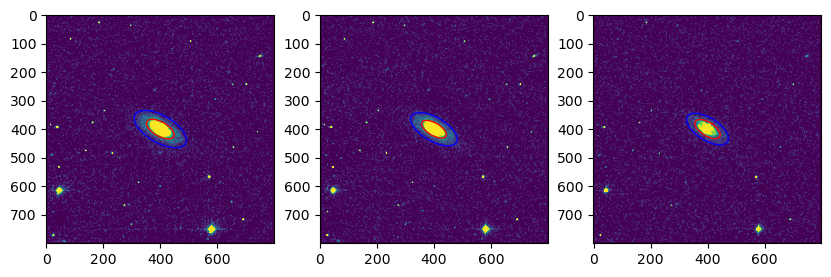

In [21]:
survey='2MASS'
target='NGC3705'
obs_thresh=1
H_hdr=fits.open(surveys[survey][3])[0].header
J_hdr=fits.open(surveys[survey][4])[0].header
K_hdr=fits.open(surveys[survey][5])[0].header
H_im=fits.open(surveys[survey][3])[0].data.byteswap().newbyteorder()
J_im=fits.open(surveys[survey][4])[0].data.byteswap().newbyteorder()
K_im=fits.open(surveys[survey][5])[0].data.byteswap().newbyteorder()
fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(10,5))

J_bkg_mean,J_bkg_med,J_bkg_rms=sigma_clipped_stats(J_im)
J_objects= sep.extract(J_im,obs_thresh,err=J_bkg_rms)
ind=np.argmax([el[15]*el[16] for el in J_objects])
x=J_objects['x'][ind]
y=J_objects['y'][ind]
a=J_objects['a'][ind]
b=J_objects['b'][ind]
theta=J_objects['theta'][ind]
e1 = Ellipse(xy=(x, y),
                width=6*a,
                height=6*b,
                angle=theta * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('blue')
ax1.add_artist(e1)
kronrad, krflag = sep.kron_radius(J_im, [x], [y], [a], [b], [theta], 6.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(J_im, aper)
net=phot_table['aperture_sum'][0]
print('Net',net)
#SN_gal=net/np.sqrt(float(J_hdr['JSKYVAL'])*aper.area+net+aper.area*float(hdr['JSKYSIG'])**2)
SN_test=net/np.sqrt(net/60+4*aper.area*(2*1.7*J_bkg_rms)**2+(4*aper.area*0.024*J_bkg_rms))
#print('J_S/N',SN_gal)
print('J_S/N_test',SN_test)
print('J_Mag=',-2.5*np.log10(float(net))+float(J_hdr['JMAGZP'])+0.91,' dM=',1/SN_test)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax1.add_artist(e_app)

H_bkg_mean,H_bkg_med,H_bkg_rms=sigma_clipped_stats(H_im)
H_objects= sep.extract(H_im,obs_thresh,err=H_bkg_rms)
ind=np.argmax([el[15]*el[16] for el in H_objects])
x=H_objects['x'][ind]
y=H_objects['y'][ind]
a=H_objects['a'][ind]
b=H_objects['b'][ind]
theta=H_objects['theta'][ind]
e1 = Ellipse(xy=(x, y),
                width=6*a,
                height=6*b,
                angle=theta * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('blue')
ax2.add_artist(e1)
kronrad, krflag = sep.kron_radius(H_im, [x], [y], [a], [b], [theta], 6.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(H_im, aper)
net=phot_table['aperture_sum'][0]
print('Net',net)
#SN_gal=net/np.sqrt(float(hdr['HSKYVAL'])*aper.area+net+aper.area*float(hdr['HSKYSIG'])**2)
SN_test=net/np.sqrt(net/60+4*aper.area*(2*1.7*H_bkg_rms)**2+(4*aper.area*0.024*H_bkg_rms))
print('H_S/N',SN_test)
print('H_Mag=',-2.5*np.log10(float(net))+float(hdr['HMAGZP'])+1.39,' dM=',1/SN_test)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax2.add_artist(e_app)

K_bkg_mean,K_bkg_med,K_bkg_rms=sigma_clipped_stats(K_im)
K_objects= sep.extract(K_im,obs_thresh,err=K_bkg_rms)
ind=np.argmax([el[15]*el[16] for el in K_objects])
x=K_objects['x'][ind]
y=K_objects['y'][ind]
a=K_objects['a'][ind]
b=K_objects['b'][ind]
theta=K_objects['theta'][ind]
kronrad, krflag = sep.kron_radius(K_im, [x], [y], [a], [b], [theta], 6.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(K_im, aper)
net=phot_table['aperture_sum'][0]
print('Net',net)
#SN_gal=net/np.sqrt(float(hdr['KSKYVAL'])*aper.area+net+aper.area*float(hdr['KSKYSIG'])**2)
SN_test=net/np.sqrt(net/60+4*aper.area*(2*1.7*K_bkg_rms)**2+(4*aper.area*0.024*K_bkg_rms))
print('K_S/N',SN_test)
print('K_Mag=',-2.5*np.log10(float(net))+float(K_hdr['KMAGZP'])+1.85,' dM=',1/SN_test)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
e1 = Ellipse(xy=(x, y),
                width=6*a,
                height=6*b,
                angle=theta * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('blue')
ax3.add_artist(e1)
ax3.add_artist(e_app)
ax1.imshow(J_im,vmin=0,vmax=10*J_bkg_rms)
ax2.imshow(H_im,vmin=0,vmax=10*H_bkg_rms)
ax3.imshow(K_im,vmin=0,vmax=10*K_bkg_rms)

## WISE ##

./WISE/MCG06
S/N= 24.55348163389147
W1_mag= 11.156181498166413 dMag= 0.041167011987575476
S/N= 13.856391963732111
W2_mag= 11.067746930550934 dMag= 0.07250754603110209
S/N= 1.884062667362034
W3_mag= 5.993656898678763 dMag= 0.5309035429179874
S/N= 7.829236562214564
W4_mag= 6.5601243903140025 dMag= 0.128288840917438


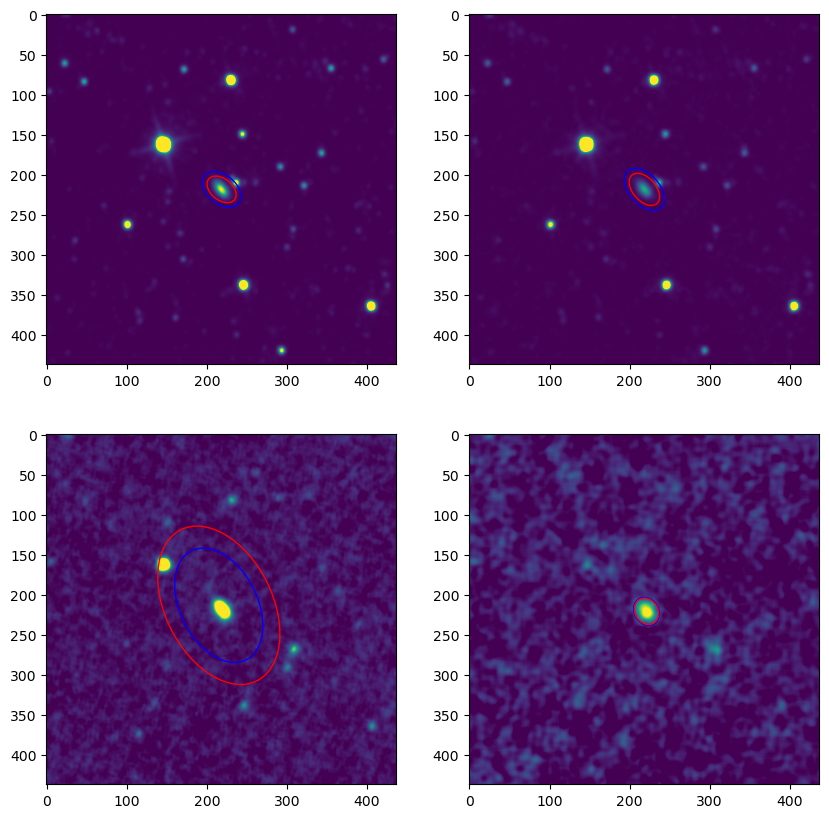

In [26]:
survey='WISE'
target='MCG05'
obj_ind=1
obs_thresh=1
obj_fold=surveys[survey][obj_ind]
obj_name=obj_fold.split('/')[-1]
print(obj_fold)
files=glob(obj_fold+'/*')
#print(files)
W1_hdr=fits.open([file for file in files if 'w1-int' in file][0])[0].header
W2_hdr=fits.open([file for file in files if 'w2-int' in file][0])[0].header
W3_hdr=fits.open([file for file in files if 'w3-int' in file][0])[0].header
W4_hdr=fits.open([file for file in files if 'w4-int' in file][0])[0].header
W1_im=fits.open([file for file in files if 'w1-int' in file][0])[0].data.byteswap().newbyteorder()
W2_im=fits.open([file for file in files if 'w2-int' in file][0])[0].data.byteswap().newbyteorder()
W3_im=fits.open([file for file in files if 'w3-int' in file][0])[0].data.byteswap().newbyteorder()
W4_im=fits.open([file for file in files if 'w4-int' in file][0])[0].data.byteswap().newbyteorder()
W1_unc=fits.open([file for file in files if 'w1-unc' in file][0])[0].data.byteswap().newbyteorder()
W2_unc=fits.open([file for file in files if 'w2-unc' in file][0])[0].data.byteswap().newbyteorder()
W3_unc=fits.open([file for file in files if 'w3-unc' in file][0])[0].data.byteswap().newbyteorder()
W4_unc=fits.open([file for file in files if 'w4-unc' in file][0])[0].data.byteswap().newbyteorder()
W1_bkg_med=W1_hdr['MEDINT']
W1_bkg_rms=W1_hdr['ROBSIG']
W2_bkg_med=W2_hdr['MEDINT']
W2_bkg_rms=W2_hdr['ROBSIG']
W3_bkg_med=W3_hdr['MEDINT']
W3_bkg_rms=W3_hdr['ROBSIG']
W4_bkg_med=W4_hdr['MEDINT']
W4_bkg_rms=W4_hdr['ROBSIG']
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(10,10))
ax1.imshow(W1_im,vmin=W1_bkg_med,vmax=W1_bkg_med+500*W1_bkg_rms)
ax2.imshow(W2_im,vmin=W2_bkg_med,vmax=W2_bkg_med+300*W2_bkg_rms)
ax3.imshow(W3_im,vmin=W3_bkg_med,vmax=W3_bkg_med+40*W3_bkg_rms)
ax4.imshow(W4_im,vmin=W4_bkg_med,vmax=W4_bkg_med+20*W4_bkg_rms)

W1_objects= sep.extract(W1_im-W1_bkg_med,obs_thresh,err=W1_hdr['ROBSIG'])
#print(W1_objects)
ind=np.argmin([np.sqrt((W1_objects['x'][el]-len(W1_im[0])/2)**2+(W1_objects['y'][el]-len(W1_im)/2)**2) for el in range(len(W1_objects))])
x=W1_objects['x'][ind]
y=W1_objects['y'][ind]
a=W1_objects['a'][ind]
b=W1_objects['b'][ind]
theta=W1_objects['theta'][ind]
e1 = Ellipse(xy=(x, y),
                width=6*a,
                height=6*b,
                angle=theta * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('blue')
ax1.add_artist(e1)
kronrad, krflag = sep.kron_radius(W1_im-W1_bkg_med, [x], [y], [a], [b], [theta], 6.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(W1_im, aper)
net=phot_table['aperture_sum'][0]-aper.area*W1_bkg_med
unc_table=aperture_photometry(np.square(W1_unc),aper)#New test
sig_sum=unc_table['aperture_sum'][0]#Test
sig_src=np.sqrt(net*(1+sig_sum+(np.pi/2)*((aper.area**2)/(np.shape(W1_im)[0]*np.shape(W1_im)[1]))*W1_bkg_rms**2))
SN_gal=net/sig_src
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax1.add_artist(e_app)
print('S/N=',SN_gal)
print('W1_mag=',-2.5*np.log10(net)+W1_hdr['MAGZP'],'dMag=',np.sqrt(1/SN_gal**2+W1_hdr['MAGZPUNC']**2))

W2_objects= sep.extract(W2_im-W2_bkg_med,obs_thresh,err=W2_hdr['ROBSIG'])
#print(W1_objects)
ind=np.argmin([np.sqrt((W2_objects['x'][el]-len(W2_im[0])/2)**2+(W2_objects['y'][el]-len(W2_im)/2)**2) for el in range(len(W2_objects))])
x=W2_objects['x'][ind]
y=W2_objects['y'][ind]
a=W2_objects['a'][ind]
b=W2_objects['b'][ind]
theta=W2_objects['theta'][ind]
e1 = Ellipse(xy=(x, y),
                width=6*a,
                height=6*b,
                angle=theta * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('blue')
ax2.add_artist(e1)
kronrad, krflag = sep.kron_radius(W2_im-W2_bkg_med, [x], [y], [a], [b], [theta], 6.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(W2_im, aper)
net=phot_table['aperture_sum'][0]-aper.area*W2_bkg_med
unc_table=aperture_photometry(np.square(W2_unc),aper)#New test
sig_sum=unc_table['aperture_sum'][0]#Test
sig_src=np.sqrt(net*(1+sig_sum+(np.pi/2)*((aper.area**2)/(np.shape(W2_im)[0]*np.shape(W2_im)[1]))*W2_bkg_rms**2))
SN_gal=net/sig_src
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax2.add_artist(e_app)
#print('Net',net)
print('S/N=',SN_gal)
print('W2_mag=',-2.5*np.log10(net)+W2_hdr['MAGZP'],'dMag=',np.sqrt(1/SN_gal**2+W2_hdr['MAGZPUNC']**2))

W3_objects= sep.extract(W3_im-W3_bkg_med,obs_thresh,err=W3_hdr['ROBSIG'])
#print(W1_objects)
ind=np.argmin([np.sqrt((W3_objects['x'][el]-len(W3_im[0])/2)**2+(W3_objects['y'][el]-len(W3_im)/2)**2) for el in range(len(W3_objects))])
x=W3_objects['x'][ind]
y=W3_objects['y'][ind]
a=W3_objects['a'][ind]
b=W3_objects['b'][ind]
theta=W3_objects['theta'][ind]
e1 = Ellipse(xy=(x, y),
                width=6*a,
                height=6*b,
                angle=theta * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('blue')
ax3.add_artist(e1)
kronrad, krflag = sep.kron_radius(W3_im-W3_bkg_med, [x], [y], [a], [b], [theta], 6.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(W3_im, aper)
net=phot_table['aperture_sum'][0]-aper.area*W3_bkg_med
unc_table=aperture_photometry(np.square(W3_unc),aper)#New test
sig_sum=unc_table['aperture_sum'][0]#Test
sig_src=np.sqrt(net*(1+sig_sum+(np.pi/2)*((aper.area**2)/(np.shape(W3_im)[0]*np.shape(W3_im)[1]))*W3_bkg_rms**2))
SN_gal=net/sig_src
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax3.add_artist(e_app)
#print('Net',net)
print('S/N=',SN_gal)
print('W3_mag=',-2.5*np.log10(net)+W3_hdr['MAGZP'],'dMag=',np.sqrt(1/SN_gal**2+W3_hdr['MAGZPUNC']**2))

W4_objects= sep.extract(W4_im-W4_bkg_med,obs_thresh,err=W3_hdr['ROBSIG'])
#print(W1_objects)
ind=np.argmin([np.sqrt((W4_objects['x'][el]-len(W4_im[0])/2)**2+(W4_objects['y'][el]-len(W4_im)/2)**2) for el in range(len(W4_objects))])
x=W4_objects['x'][ind]
y=W4_objects['y'][ind]
a=W4_objects['a'][ind]
b=W4_objects['b'][ind]
theta=W4_objects['theta'][ind]
e1 = Ellipse(xy=(x, y),
                width=6*a,
                height=6*b,
                angle=theta * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('blue')
ax4.add_artist(e1)
kronrad, krflag = sep.kron_radius(W4_im-W4_bkg_med, [x], [y], [a], [b], [theta], 6.0)
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
phot_table = aperture_photometry(W4_im, aper)
net=phot_table['aperture_sum'][0]-aper.area*W4_bkg_med
unc_table=aperture_photometry(np.square(W4_unc),aper)#New test
sig_sum=unc_table['aperture_sum'][0]#Test
sig_src=np.sqrt(net*(1+sig_sum+(np.pi/2)*((aper.area**2)/(np.shape(W4_im)[0]*np.shape(W4_im)[1]))*W4_bkg_rms**2))
SN_gal=net/sig_src
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax4.add_artist(e_app)
#print('Net',net)
print('S/N=',SN_gal)
print('W4_mag=',-2.5*np.log10(net)+W4_hdr['MAGZP'],'dMag=',np.sqrt(1/SN_gal**2+W4_hdr['MAGZPUNC']**2))


